In [180]:
import math
import scipy
import scipy.io
import scipy.signal as s
import scipy.interpolate as interp
import matplotlib.pyplot as plt

import statsmodels.api as sm
import numpy as np

def todB(x): return 10 * np.log10(abs(x))
def amp(x): return 10**(x/10)

def t90(x):
    total = sum(x)
    peak = int(len(x)/2)
    for i in range(1,10000):
        if(sum(x[peak-i:peak+i])>=(0.9*total)):
            return 2*i/fs
    return -99999
    
#   t90(x) gradually increases a symetric window around the peak untill it reaches 90% of the total
#   returns the window size in units of seconds

full = scipy.io.loadmat('23B_121_86_FullGun.mat')
partial = scipy.io.loadmat('23B_123_409_NoGun.mat')

test = scipy.io.loadmat('MGL1212_Line_AT.mat')

f1 = full['Data1']
f2 = full['Data2']

p1 = partial['Data1']
p2 = partial['Data2']

#f1=test['Data1']

f1=np.transpose(f1) #puts data on it's side (easier to work with rows)
f1=f1[::-1]#reverses 
f1 = f1*(10**6) #convert to micro pascals
fs = 500

In [181]:
# I. High Pass Filter to remove streamer noise

#Applies 3 biquad filters with 11hz cutoff to remove streamer noise, parameters come from fdatool

sos=[[1,-2,1,1,-1.82570619168342,0.881881926844246],[1,-2,1,1,-1.65627993129105,0.707242535896459],[1,-2,1,1,-1.57205200320457,0.620422971870477]]

fData = []
for row in f1:
    fData.append(s.sosfilt(sos,row))
fData=np.asarray(fData)#recast as ndarray


In [182]:
# II. Adjusting for group length (+6dB)
fData = amp(6)*fData # adjusted filtered data

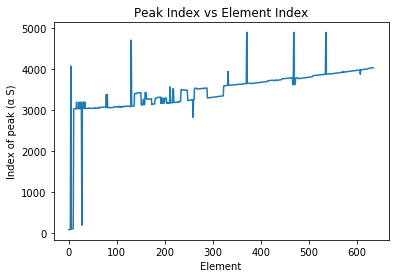

In [183]:
# III. Windowing Around Peak (2s before and after)
peak=[]
#forward 2 s
winData = []#windowed data
for row in fData:
    peak1 = np.argmax(row[0:10*fs])
    if(peak1>1000):#if the peak is 2s from the 0 index (window can be 4s)
        DATA = row[peak1-2*fs:peak1+2*fs]#Keep data around the peak (2s before and after)
    else:
        w = row[peak1:peak1+2*fs]#one-sided window
        wf = w#flipped window without the peak index
        wf=wf[::-1]
        wf=wf[0:len(wf)-1]
        #wf=np.zeros(len(wf))###
        DATA = np.concatenate((wf,w))#forward window of 2s mirrored around the peak
    winData.append(DATA)
    peak.append(peak1)
winData = np.asarray(winData)#recast as ndarray
plt.plot(peak)
plt.title('Peak Index vs Element Index')
plt.xlabel('Element')
plt.ylabel('Index of peak (α S)')
plt.show()


[ 179.78805488  184.62110194  184.27240543  177.13253157   91.1693346
  182.14370811  179.58192968  178.89009971  178.25699216  180.29425126
  165.40476911  165.24631396  164.96266512  166.07379408  165.56263879
  165.94181589  166.88343864  165.74382072  166.35464545  165.60933298
  166.06982618  166.98110109  166.63340966  166.01183283  166.0483608
  167.676584    166.6666152   174.17540625  165.85468396  166.22963052
  167.52585814  166.09360283  165.76628591  166.73242682  165.94498568
  166.08247013  165.55433417  165.65908543  166.27294842  152.14719045
  166.31031624  166.26503132  165.9964009   166.37506211  166.40223255
  164.8949895   166.40342985  166.27289252  166.3578086   165.96248875
  166.01174742  166.16185374  165.16760383  165.36984451  164.80125292
  164.40888373  164.42464297  163.85884365  164.36563852  164.40418462
  164.20168019  164.23531464  164.36175788  164.20455661  163.79783115
  164.1212298   163.75754469  163.49049801  164.10986443  164.16473886
  164.60

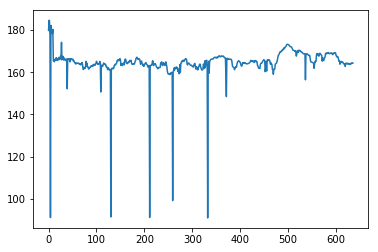

In [184]:
# IV. Calculate RMS of power

squaredPressure = np.multiply(winData,winData)

RMS = []
T90 = []
i = 0

for row in squaredPressure:
    T90a=t90(row)
    RMS.append(10*np.log10(sum(row)/(fs*T90a)))#integrate squared pressure / T90
    i = i+1
    T90.append(T90a)
RMS = np.asarray(RMS)#recast as ndarray
print(RMS)
print(T90)
plt.plot(RMS)
plt.show()

In [185]:
#IV. Calculate SEL Energy Density (dB)

SEL=[]

i = 0
for rms in RMS:
    SEL.append(rms+10*np.log10(T90[i]))# RMS + log(T90)
    i = i+1
SEL = np.asarray(SEL)#recast as ndarray
print(SEL)

scipy.io.savemat('Data1.mat', mdict={'SEL':SEL,'RMS':RMS,'Windowed': winData,'Filtered':fData,'Original':f1})#debug

[ 170.57986734  174.44381427  173.71723216  167.6247118    96.71301461
  171.17460798  169.02675641  168.52797798  167.49978502  168.61934039
  169.41187547  169.21179434  169.0990151   170.28324814  169.85693144
  170.3760105   170.08905544  169.92019812  170.42345215  169.83851279
  170.46631047  170.27711357  170.64051602  170.3190317   170.32970874
  170.60799883  170.76932484  161.33543969  170.18758081  170.22290584
  170.19287781  170.01000986  169.73176629  169.84572635  170.10806155
  170.04097389  169.52677998  169.5684365   170.25234851  157.40023055
  170.34495325  170.34743097  170.05839513  170.30554677  170.19710069
  168.970598    170.4858295   170.33488675  170.4537588   169.98338226
  169.80661556  169.8836066   169.13308421  169.445453    169.01070698
  168.69670884  168.68650122  168.1207019   168.78101891  168.93736802
  168.90284372  168.93647817  168.78969014  168.48590455  168.19431544
  167.9521991   167.92062056  167.9434257   168.50003171  168.49763571
  168.

In [195]:
#V. Remove noisy or inaccurate channels
RMS2=[]
SEL2=[]
RMS_diff=[]
inaccurate=[]
noisy=[]
N=8
RMS_avg = np.convolve(RMS, np.ones((N,))/N, mode='valid')#rolling average of RMS
RMS_avg = np.concatenate((RMS_avg,RMS[len(RMS_avg):len(RMS_avg)+N-1]))#pad RMS_avg
RMS_diff.append(-99999)#first index
for i in range(1,len(RMS)):
    RMS_diff.append(np.abs(RMS[i]-RMS[i-1]))#differential RMS
#Find
indexes = list(set(np.concatenate((inaccurate,noisy))))
for index in sorted(indexes, reverse=True):#remove bad channels
    del RMS[index]
#plt.plot(RMS_diff) 
#plt.hist(RMS_diff)
#print(np.mean(RMS_diff))
#plt.show()
print('inaccurate:',inaccurate,'\nnoisy:',noisy)


inaccurate: [] 
noisy: []


In [ ]:
#VI. Fitting Data
b = np.linspace(0,len(RMS2),len(RMS2))

'''SELmodel = np.polyfit(b, SEL2, deg=8)
RMSmodel = np.polyfit(b, RMS2, deg=8)

SELpol = np.poly1d(SELmodel) 
RMSpol = np.poly1d(RMSmodel)

SEL180 = -1
SEL160 = -1
RMS180 = -1
RMS160 = -1

for i in range(0,1000):
    if(SELpol(i)>180):
        SEL180 = i
    if(SELpol(i)>160):
        SEL160 = i
    if(RMSpol(i)>180):
        RMS180 = i
    if(RMSpol(i)>160):
        RMS160 = i
SEL180 = SEL180*(12.5/1000)#converts from index to length in km
SEL160 = SEL160*(12.5/1000)
RMS180 = RMS180*(12.5/1000)
RMS160 = RMS160*(12.5/1000)

print('SEL180 =',SEL180)#Safety radii
print('SEL160 =',SEL160)
print('RMS180 =',RMS180)
print('RMS160 =',RMS160)

plt.plot(b,SELpol(b))
plt.show()'''